## Checks

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
%matplotlib inline

In [2]:
# Which downsampling norm to use: This selects input data:
# dd: Deduplicated downsampled data
# aa: Analyse all reads in data, downsample based on number of PF reads
DS_MODE = "aa" # Note: AA mode should be used for this check

### Load Picard data

#### Step 1 is to load all the metrics from the downsampled data.

In [3]:
def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data

In [4]:
samples = []
for bam in glob("30_downsample/*-{}_DS_MD.AlignmentSummaryMetrics.txt".format(DS_MODE)):
    basepath = re.sub(r"_MD\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['_MD.AlignmentSummaryMetrics', '_MD.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '_MD.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

In [5]:
print(len(samples))

40


#### Step 2: Get original number of PF reads from before downsampling.

In [6]:
inital_read_counts = []
for alignment_txt in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    library = re.search(r"/([^/]+)\.AlignmentSummaryMetrics.txt", alignment_txt).group(1)
    new_data = load_picard(alignment_txt)
    inital_read_counts.append({'LIBRARY': library, 'INITIAL_READS': int(new_data['TOTAL_READS']),
                                    'INITIAL_READS_PER_END': int(new_data['TOTAL_READS']) / 2})

In [7]:
dedup_read_counts = []
for rc_txt in glob("20_piccard_dd/*.readCount.txt"):
    library = re.search(r"/([^/]+)\.readCount\.txt", rc_txt).group(1)
    rc = int(open(rc_txt).read().strip())
    dedup_read_counts.append({'LIBRARY': library, 'DEDUPLICATED_READS': rc, 'DEDUPLICATED_READS_PER_END': rc/2})

#### Step 3: Get arabidopsis metrics.

In [8]:
arabidopsis_samples = []
for bam in glob("arabidopsis/20_piccard/*.bam"):
    basepath = re.sub(r"\.bam$", "", bam)
    data = {}
    for metrics in ['.AlignmentSummaryMetrics', '.InsertSizeMetrics',
                    '.MarkDuplicatesMetrics', '.WgsMetrics']:
        new_data = load_picard("{}{}.txt".format(basepath, metrics))
        if any(k in data for k in new_data):
            print("Duplicate key {} found in {}".format(k, metrics))
        data.update(new_data)
    arabidopsis_samples.append(data)

In [9]:
print(samples[0]['LIBRARY'])
#print(inital_read_counts[0]['LIBRARY'])
print("TODO. There is no arabidopsis yet.")

Quanta-10ng-3
TODO. There is no arabidopsis yet.


In [10]:
main_df = pd.DataFrame(samples).reindex().convert_objects(convert_numeric=True)
in_reads_df = pd.DataFrame(inital_read_counts)
dd_reads_df = pd.DataFrame(dedup_read_counts)
arabidopsis_df = pd.DataFrame(arabidopsis_samples)

df = pd.merge(
    pd.merge(
        pd.merge(
            main_df,
            arabidopsis_df,
            on='LIBRARY', suffixes=('', '_AR')).reindex(),
        in_reads_df, 
        on='LIBRARY').reindex(),
    dd_reads_df, on='LIBRARY')

df['Kit'] = df.LIBRARY.str.split("-").str.get(0)
df['Conc'] = df.LIBRARY.str.split("-").str.get(1)
df_100 = df.loc[df.Conc == "100ng"]

/Users/paalmbj/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [11]:
print("Number of entries: ", len(df))

Number of entries:  40


## Again with the duplicates


In [12]:
cluster_duplication = pd.read_table('01_data_qc/fastdup.txt')
cluster_duplication['Sample'] = cluster_duplication.FILE.str.split("_").str.get(0).str.split("-", n=1).str[1]
sample_fastdup = cluster_duplication.groupby("Sample", as_index=False).sum()[["Sample","NUM_READS","READS_WITH_DUP"]]
sample_fastdup['DUP_RATIO'] = sample_fastdup.READS_WITH_DUP / sample_fastdup.NUM_READS
sample_fastdup.head(n=1)

,Sample,NUM_READS,READS_WITH_DUP,DUP_RATIO
0,Kapa-100ng-1,120913253,6397146,0.052907


concordance fastdup / Picard

In [13]:
df["PCT_OPTICAL_DUPLICATES"] = df.READ_PAIR_OPTICAL_DUPLICATES / df.READ_PAIRS_EXAMINED
merge_df = pd.merge(df, sample_fastdup, left_on="LIBRARY", right_on="Sample")
print("merged length", len(merge_df))


df["DUP_RATIO"] = df.PCT_OPTICAL_DUPLICATES
df["Source"] = "Picard"
sample_fastdup["Source"] = "fastdup"
both_df = pd.concat((df, sample_fastdup), sort=False)

merged length 40


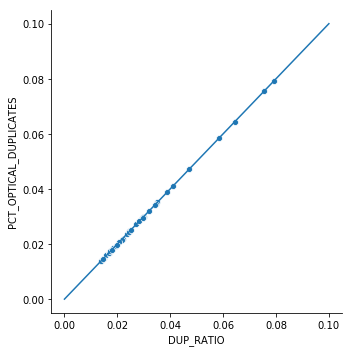

In [14]:
sns.relplot(data=both_df, x="DUP_RATIO", y="PCT_OPTICAL_DUPLICATES")
plt.plot((0, 0.1), (0, 0.1))